# Bayesian Computing in Python 

Working through some examples in the book. Starting with understaind the 
Metropolis-Hastings MCMC sampler.

Sampling for a beta-binomial model.

In [1]:
# Setup
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from scipy import stats
from scipy.stats import entropy
from scipy.optimize import minimize

az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(521)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = stats.beta(α, β).pdf(θ)
        like  = stats.bernoulli(θ).pmf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob

Generate random fake data.

In [3]:
Y = stats.bernoulli(0.7).rvs(20)

Metropolis-Hastings MCMC.

In [4]:
n_iters = 1000
can_sd = 0.05
α = β =  1
θ = 0.5
trace = {"θ":np.zeros(n_iters)}
p2 = post(θ, Y, α, β)

for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1)
    p1 = post(θ_can, Y, α, β)
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1
    
    trace["θ"][iter] = θ

Trace and density plot of posterior.

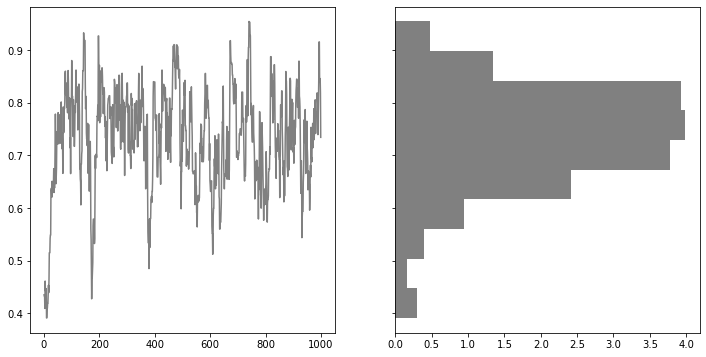

In [5]:
_, axes = plt.subplots(1,2, sharey=True, figsize = (12,6))
axes[0].plot(trace["θ"], color="0.5")
axes[1].hist(trace["θ"], color="0.5", orientation="horizontal", density=True)
plt.show()

In [6]:
# arviz summary
az.summary(trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
θ,0.73,0.1,0.57,0.92


<AxesSubplot:title={'center':'θ'}>

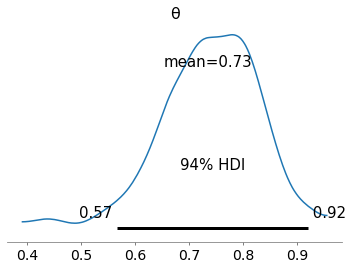

In [7]:
az.plot_posterior(trace)

Using pymc3 to build a model instead of the MCMC sampler built above.

In [8]:
# Declare a model in PyMC3
with pm.Model() as model:
    # Specify the prior distribution of unknown parameter
    θ = pm.Beta("θ", alpha=1, beta=1)

    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=θ, observed=Y)

    # Sample from the posterior distribution
    idata = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [9]:
pred_dists = (pm.sample_prior_predictive(1000, model)["y_obs"],
              pm.sample_posterior_predictive(idata, 1000, model)["y_obs"])

/Users/ryangan/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Can also view PYMC object formula using the following formula.

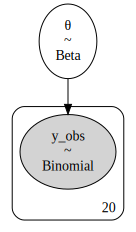

In [13]:

pm.model_to_graphviz( model )

Plot of prior, prior predictive, posterior, and posterior predictive.

Text(0.5, 0, 'θ')

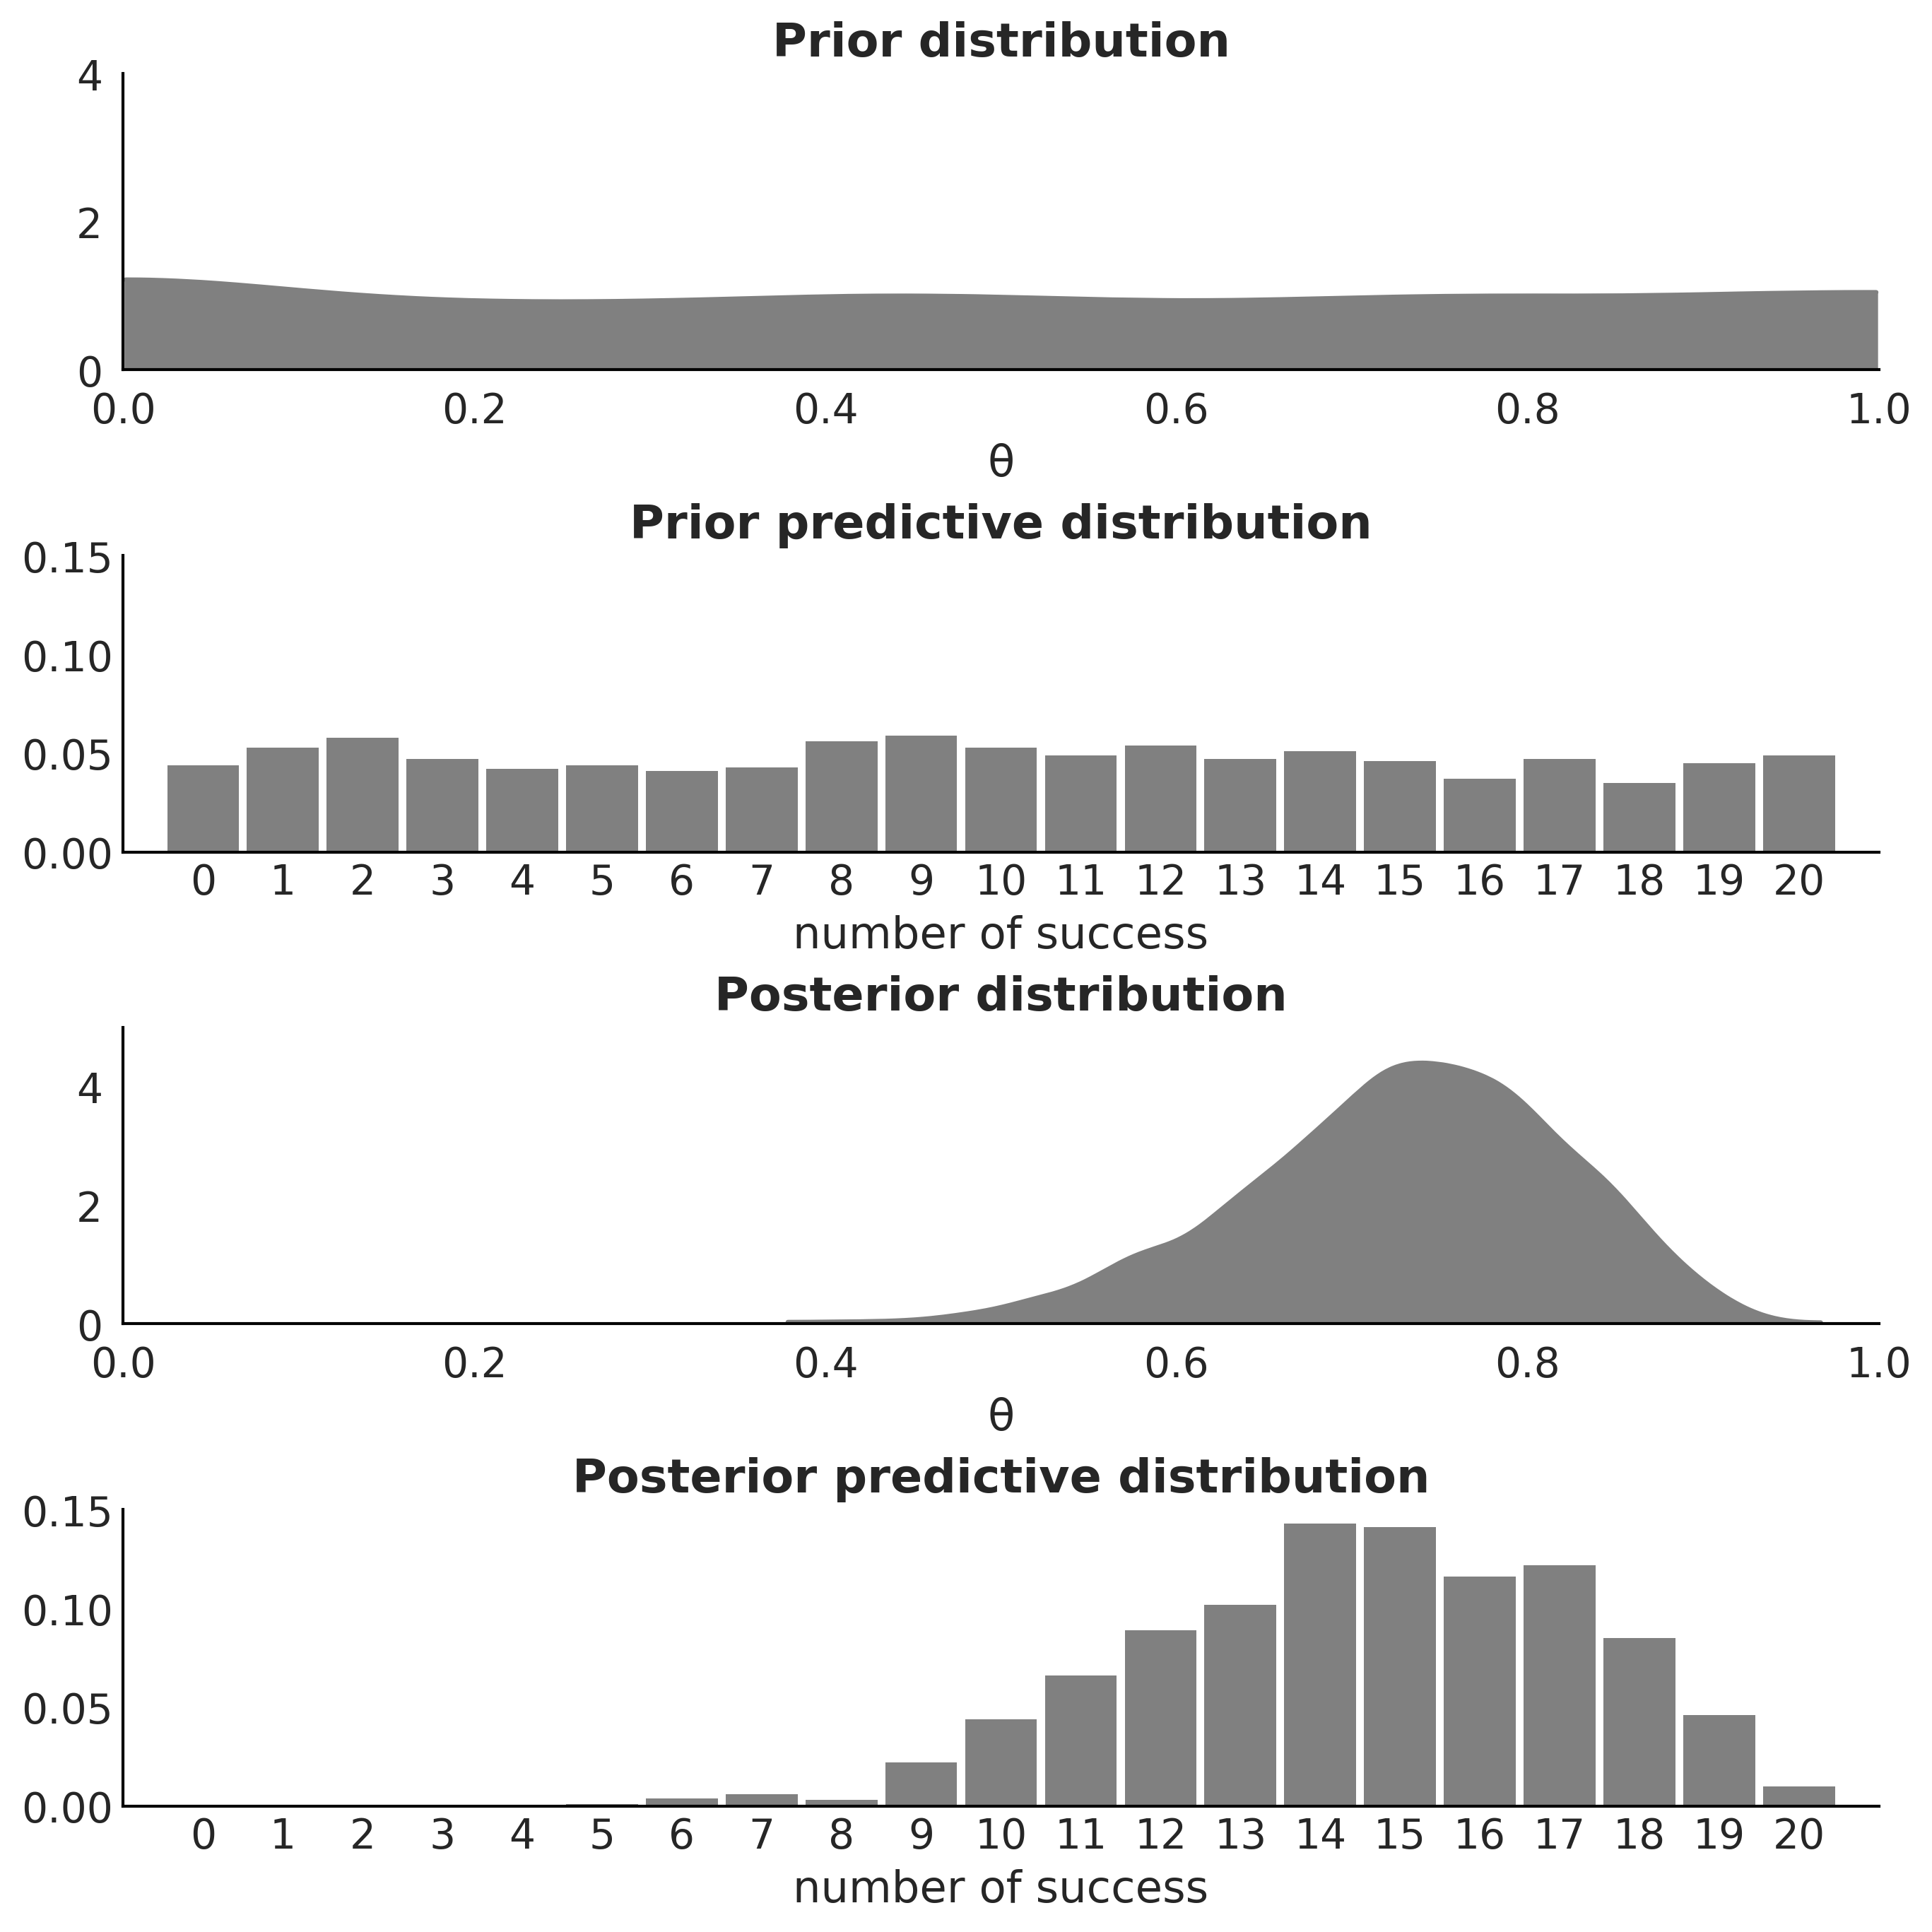

In [57]:
fig, axes = plt.subplots(4, 1, figsize=(9, 9))

for idx, n_d, dist in zip((1, 3), ("Prior", "Posterior"), pred_dists):
    az.plot_dist(dist.sum(1), hist_kwargs={"color":"0.5", "bins":range(0, 22)},
                                           ax=axes[idx])
    axes[idx].set_title(f"{n_d} predictive distribution",fontweight='bold')
    axes[idx].set_xlim(-1, 21)
    axes[idx].set_ylim(0, 0.15)
    axes[idx].set_xlabel("number of success")

az.plot_dist(θ.distribution.random(size=1000), plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[0])
axes[0].set_title("Prior distribution", fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 4)
axes[0].tick_params(axis='both', pad=7)
axes[0].set_xlabel("θ")

az.plot_dist(idata.posterior["θ"], plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[2])
             
axes[2].set_title("Posterior distribution", fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 5)
axes[2].tick_params(axis='both', pad=7)
axes[2].set_xlabel("θ")

Relationship between posterior predictive distribution and posterior is similar,
but posterior predictive distribution has a little extra uncertainy. 

This is because the posterior distribution is mean parameter value, while
the posterior predicted distribution is the entire distribution.

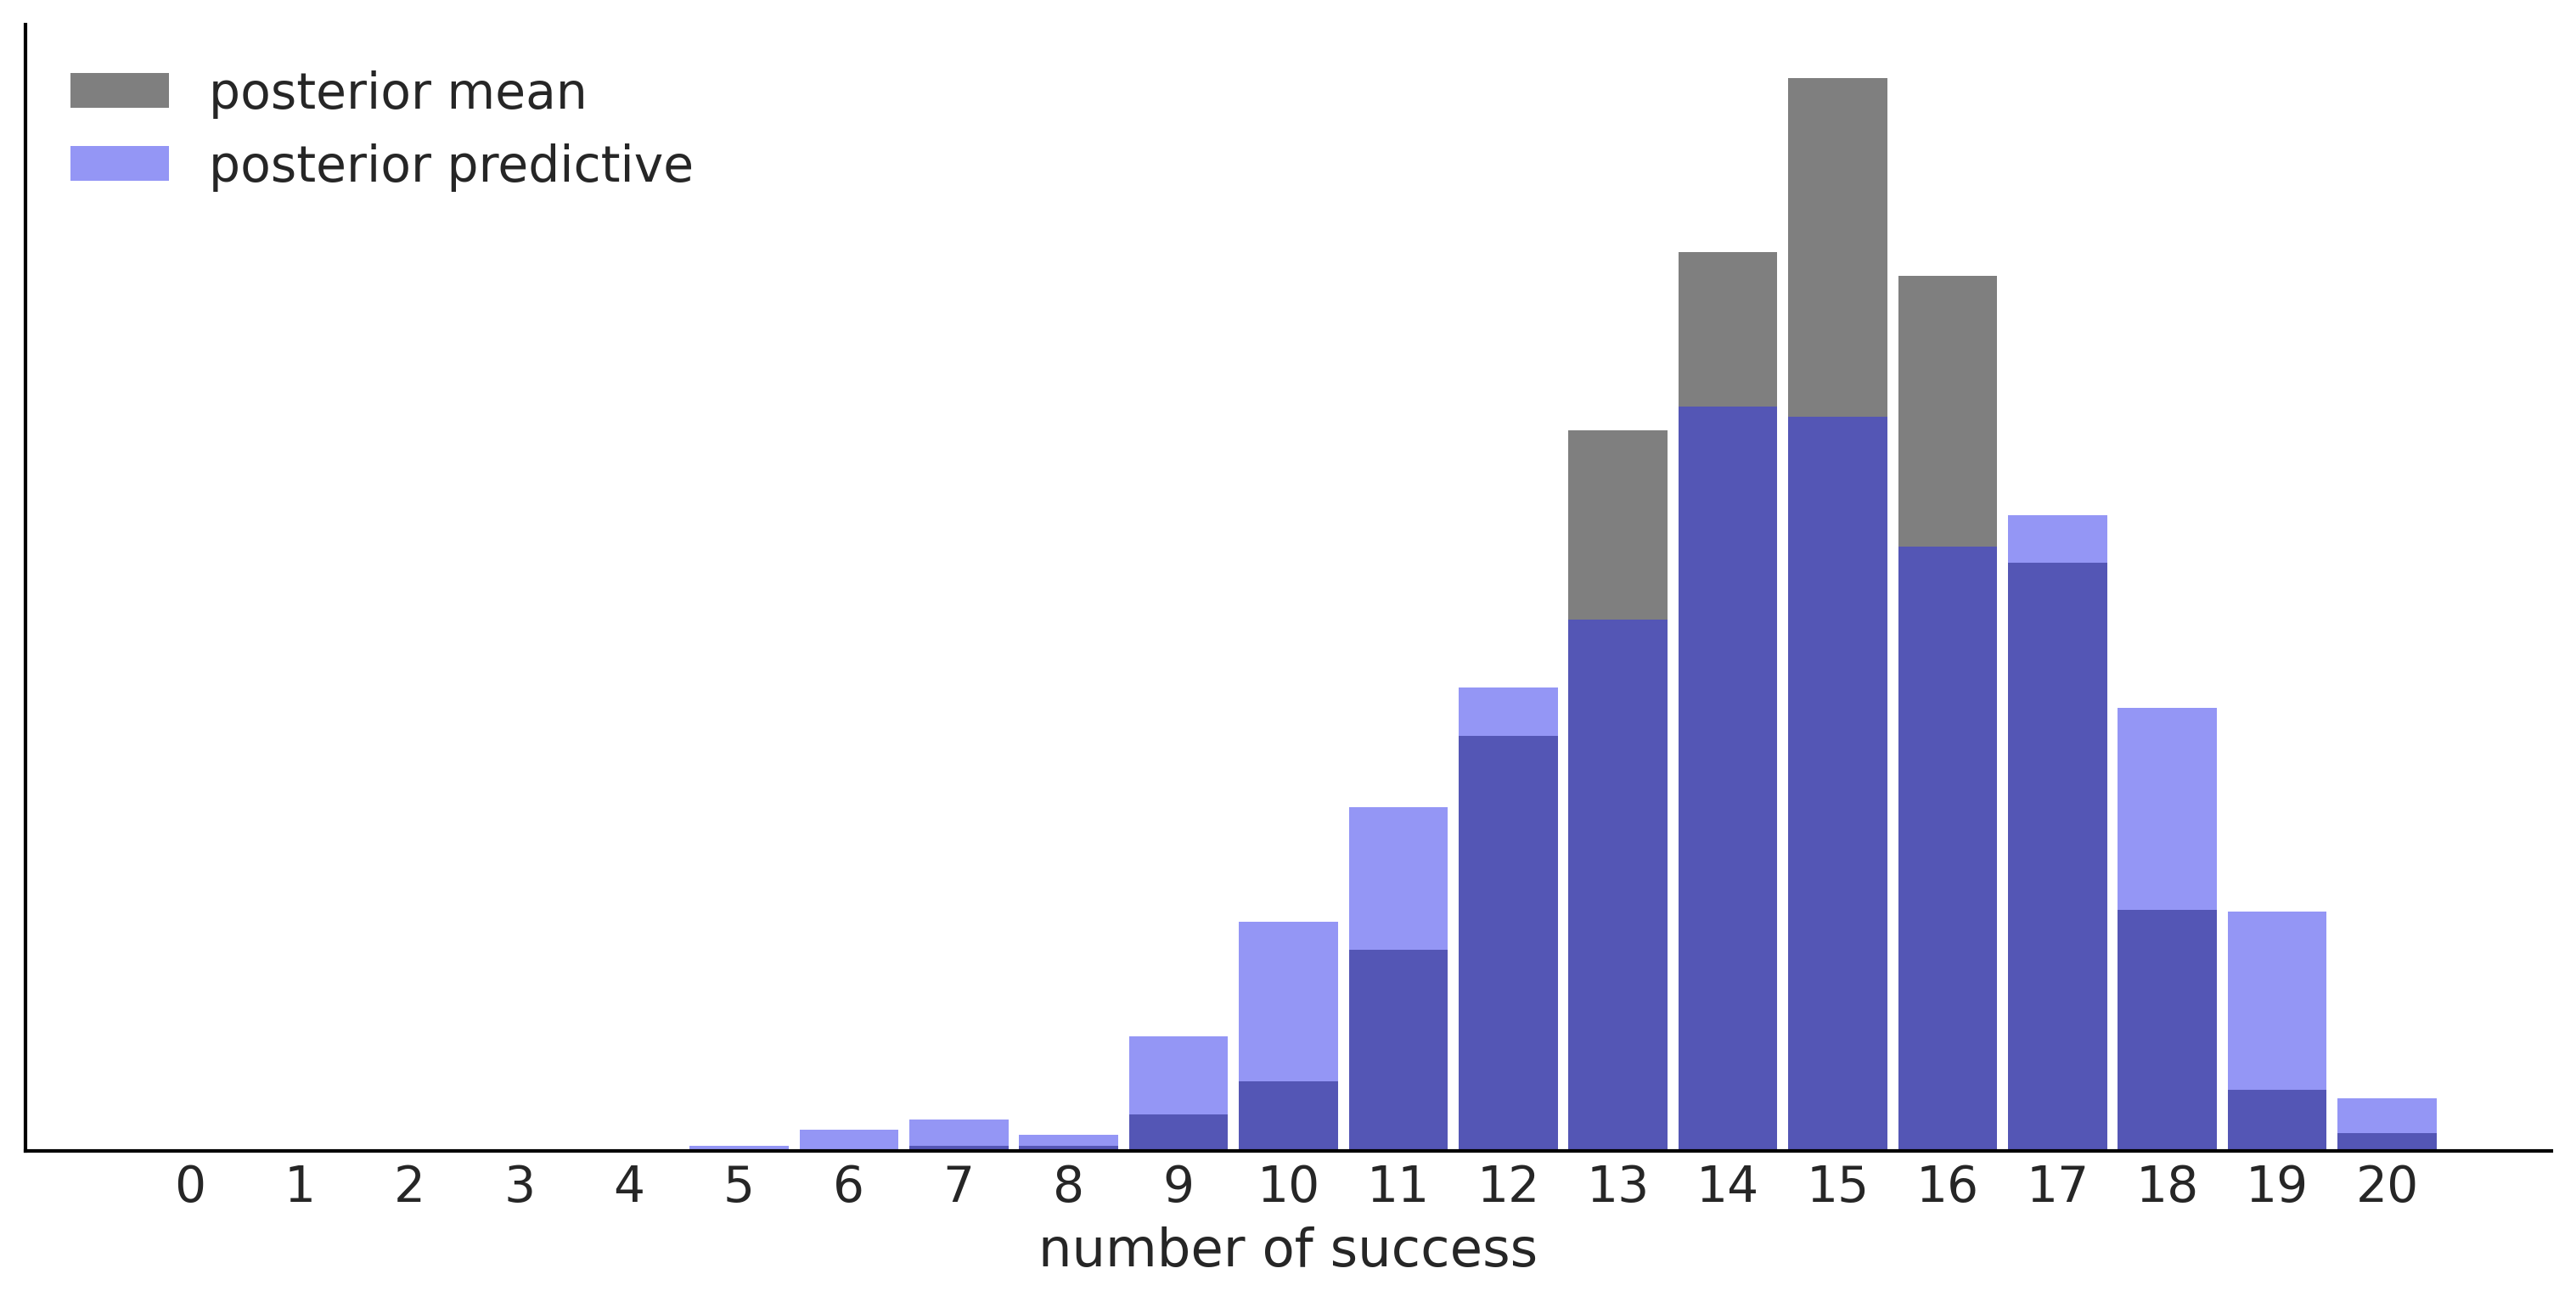

In [60]:
predictions = (model.y_obs.distribution.random({"θ":idata.posterior["θ"].mean()}, size=3000),
               pred_dists[1])

for d, c, l in zip(predictions, ("C0", "C4"), ("posterior mean", "posterior predictive")):
    ax = az.plot_dist(d.sum(1),
                      label=l,
                      figsize=(10, 5),
                      hist_kwargs={"alpha": 0.5, "color":c, "bins":range(0, 22)})
    ax.set_yticks([])
    ax.set_xlabel("number of success")

Code 1.8 on successive prior updating using 3 different priors (beta_params)
based on number of trials (N) and successes.

/var/folders/j4/x0dy2w2s14550n028vczsqdc0000gn/T/ipykernel_44748/1478554044.py:20: RuntimeWarning: invalid value encountered in true_divide
  axes[idx].plot(np.divide(y, N), 0, color="k", marker="o", ms=12)
/var/folders/j4/x0dy2w2s14550n028vczsqdc0000gn/T/ipykernel_44748/1478554044.py:20: RuntimeWarning: invalid value encountered in true_divide
  axes[idx].plot(np.divide(y, N), 0, color="k", marker="o", ms=12)
/var/folders/j4/x0dy2w2s14550n028vczsqdc0000gn/T/ipykernel_44748/1478554044.py:20: RuntimeWarning: invalid value encountered in true_divide
  axes[idx].plot(np.divide(y, N), 0, color="k", marker="o", ms=12)


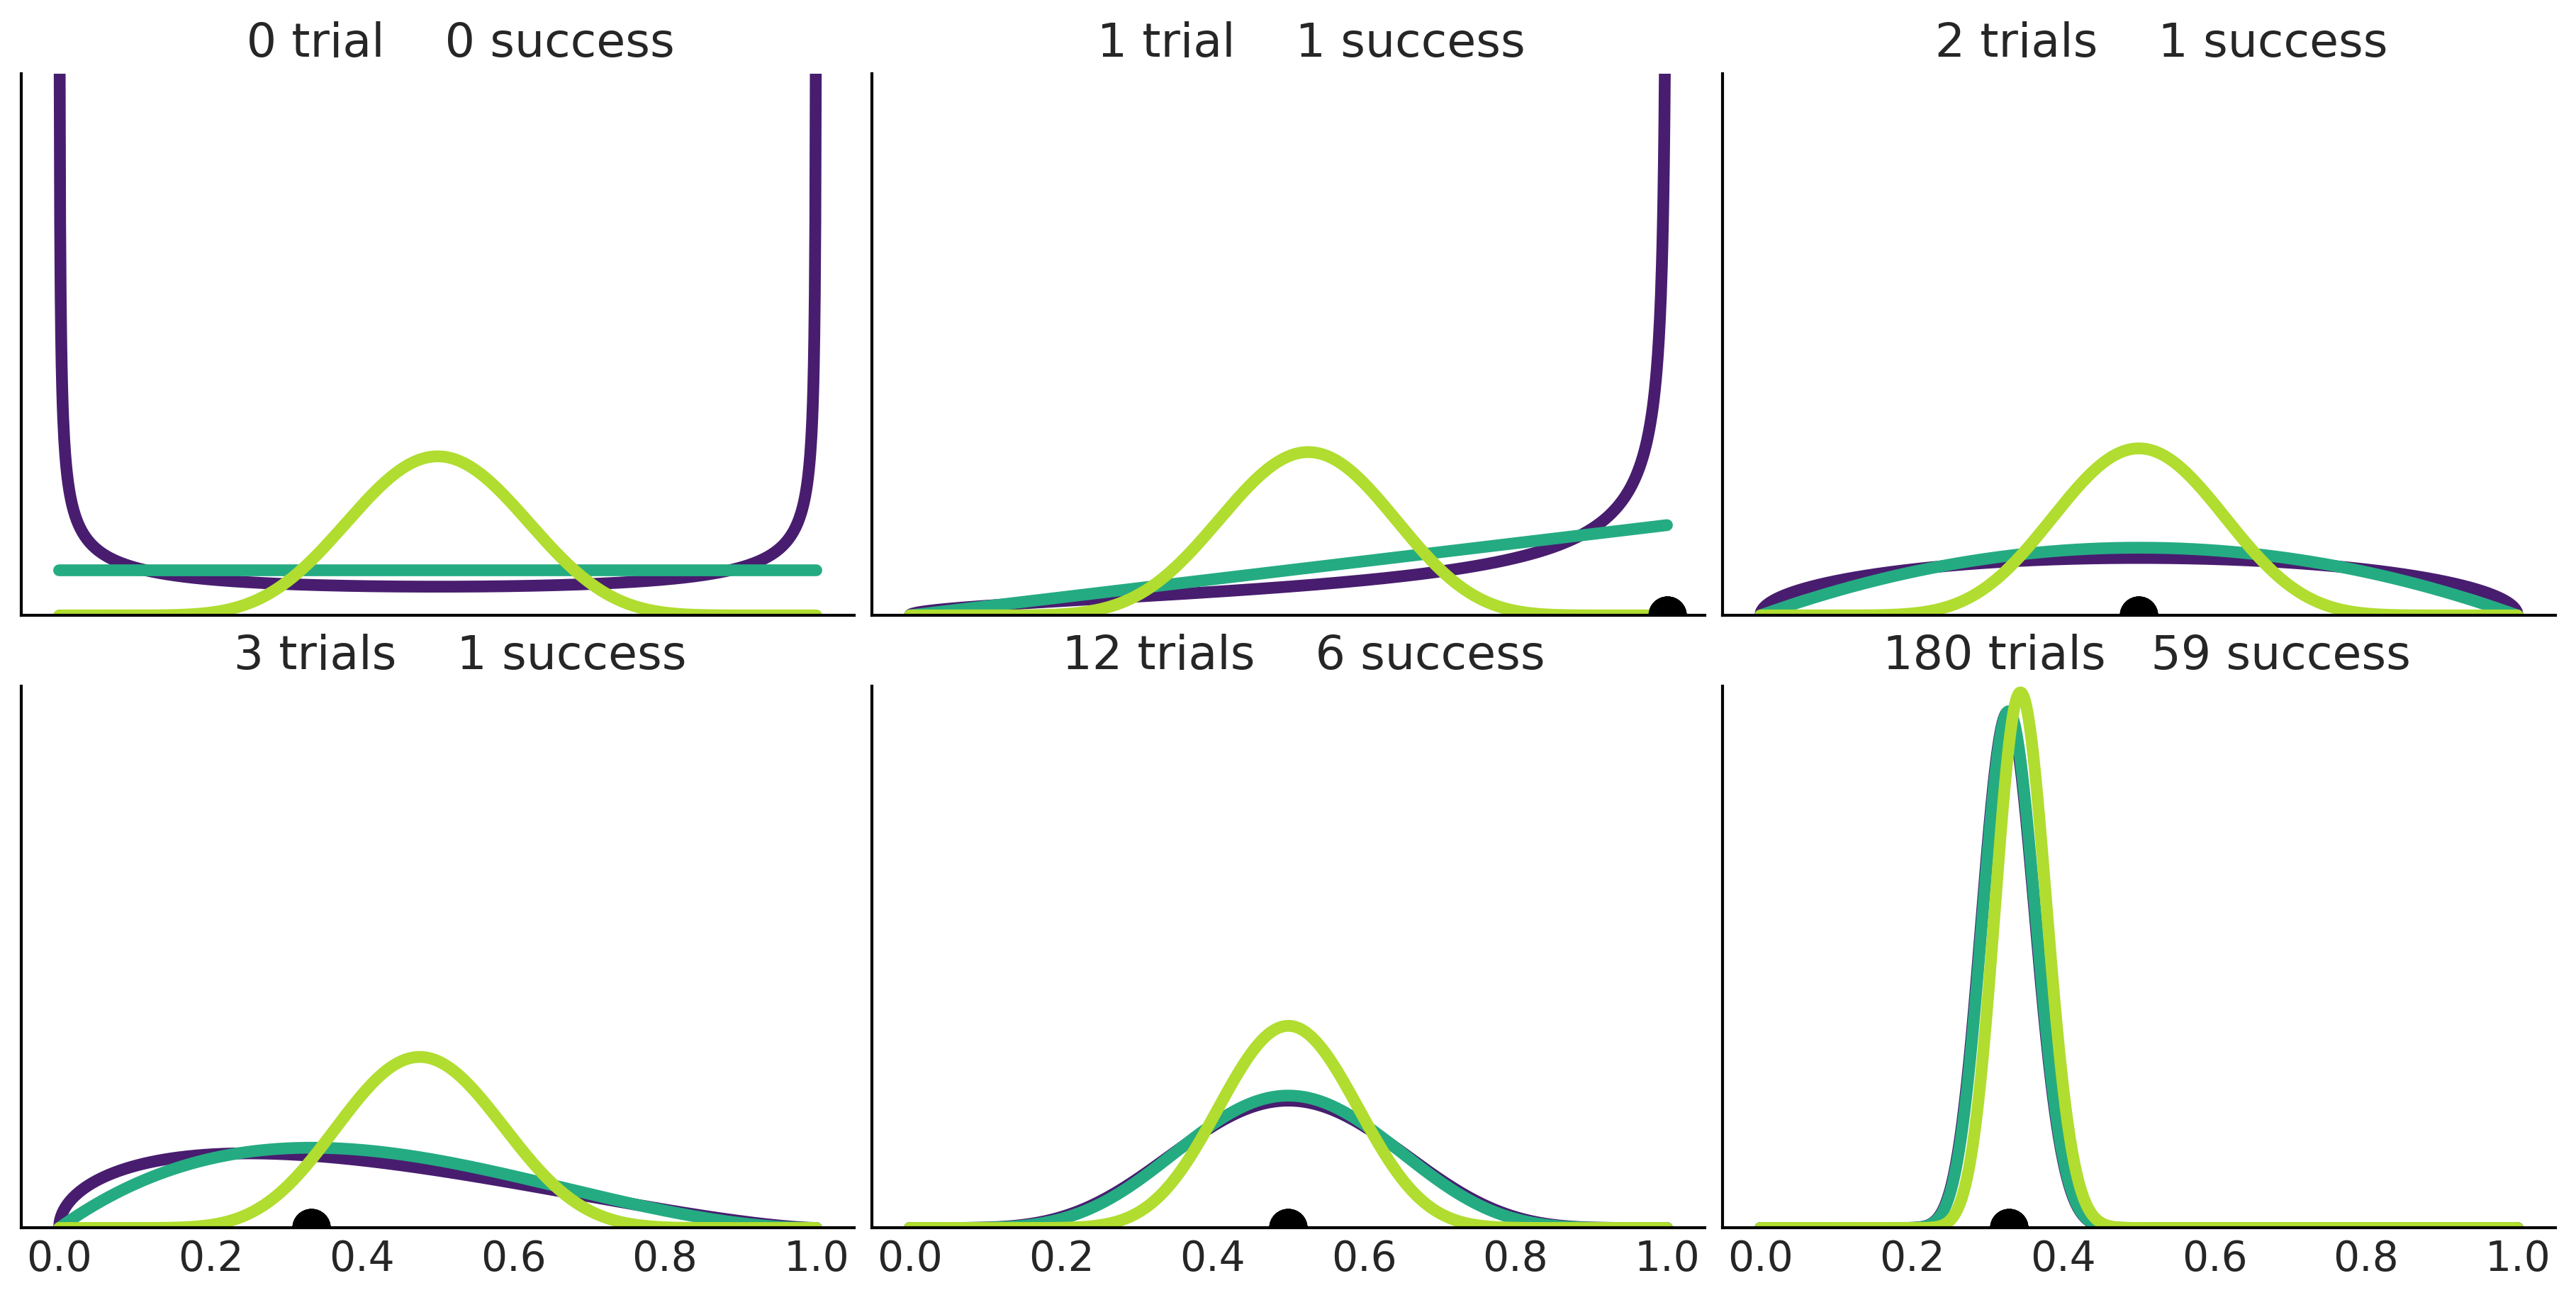

In [64]:
# code 1.8 successive prior updating
_ , axes = plt.subplots( 2 , 3 , sharey = True, sharex = True , figsize = (12,6))
axes = np.ravel( axes ) # flattens array

n_trials = [0 , 1, 2, 3, 12, 180]
success = [0, 1, 1, 1, 6, 59]
data = zip( n_trials , success )

beta_params = [ (0.5, 0.5) , (1, 1), (10, 10)]
theta = np.linspace( 0 , 1, 1500)

for idx, (N, y) in enumerate(data):
    s_n = ("s" if (N > 1) else "")
    for jdx, (a_prior, b_prior) in enumerate(beta_params):
        p_theta_given_y = stats.beta.pdf(theta , a_prior + y, b_prior + N - y)

        axes[idx].plot(theta , p_theta_given_y, lw=4, color = viridish[jdx])
        axes[idx].set_yticks([])
        axes[idx].set_ylim(0, 12)
        axes[idx].plot(np.divide(y, N), 0, color="k", marker="o", ms=12)
        axes[idx].set_title(f"{N:4d} trial{s_n} {y:4d} success")

array([0.        , 0.00066711, 0.00133422, 0.00200133, 0.00266845,
       0.00333556, 0.00400267, 0.00466978, 0.00533689, 0.006004  ])